In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as c
from matplotlib.colors import LogNorm
from astropy.visualization import quantity_support
quantity_support()
from astropy.table import QTable, Table, Column, vstack
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')

from purify_catalog import cat_purification_cores
from purify_catalog import HII_catalogs
#cat_NB3_HII_candidates, cat_MB3_HII_candidates, cat_NB3_HII, cat_MB3_HII, cat_NB6_HII_candidates, cat_MB6_HII_candidates, cat_NB6_HII, cat_MB6_HII = HII_catalogs(catNB3, catNB6, catMB3, catMB6)
catNB3_m, catMB3_m, catNB6_m, catMB6_m = cat_purification_cores(catNB3, catMB3, catNB6, catMB6)
catNB3_HII, catNB3_HII_cand, catNB3_HII_new, catMB3_HII, catMB3_HII_cand, catMB3_HII_new, catNB6_HII, catNB6_HII_cand, catNB6_HII_new, catMB6_HII, catMB6_HII_cand, catMB6_HII_new = HII_catalogs(catNB3, catNB6, catMB3, catMB6)

catB3_m = vstack([catNB3_m, catMB3_m])
catB6_m = vstack([catNB6_m, catMB6_m])

ModuleNotFoundError: No module named 'purify_catalog'

In [3]:
def thick_bb_emission(T, freq, radii):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*T))-1)).to(u.W/u.m**2/u.Hz)
    d = 8.4 * u.kpc
    S_nu = B_nu * np.pi * radii**2 / d**2 
    
    return S_nu.to(u.Jy)

In [4]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

In [5]:
def total_emission(T_thin, T_thick, freq, surf_den, r_thick):
    # create a 2D grid
    rows, cols = (len(surf_den), len(r_thick))
    arr = [[np.nan]*cols]*rows
    
    # get the dust opacity index from OH94
    kappa_ = kappa(freq)
    
    # set constants
    d = 8.4 * u.kpc
    radius = 713/2 * u.AU # beam size
    
    # fill up rows of the grid:
    for i in range(len(surf_den)):
        if (i == 787):
            print('surf_den = '+str(surf_den[i]))
            print('r_thick[138] = ' + str(r_thick[138]))
        S_nu = get_S_thin(T_thin, surf_den[i], freq, r_thick)
        S_nu_thick = thick_bb_emission(T_thick, freq, r_thick)
        S_total = (S_nu_thick + S_nu).to(u.Jy)
        # fill rows of the grid one by one
        arr[i] = S_total.value
    return arr #in jy!!!

In [6]:
def get_S_thin(T_thin, surf_den, freq, r_thick):
    d = 8.4 * u.kpc
    radius = 713/2 * u.AU
    
    kappa_ = kappa(freq)
    F_nu = np.pi * 2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled)))
    
    S_nu_hole = (F_nu / np.pi) * ((np.pi * radius**2) - (np.pi * r_thick**2)) / d**2
    
    return S_nu_hole.to(u.Jy)

In [7]:
def get_SI_params(T_thin, T_thick, surf_den, r_thick, freq1, freq2):
    d = 8.4 * u.kpc
    radius = 713/2 * u.AU
    
    S_nu_1_thin = get_S_thin(T_thin, surf_den, freq1, r_thick)
    #print('S thin 1: '+str(S_nu_1_thin))
    S_nu_2_thin = get_S_thin(T_thin, surf_den, freq2, r_thick)
    #print('S thin 2: '+str(S_nu_2_thin))
    S_nu_1_thick =  thick_bb_emission(T_thick, freq1, r_thick)
    S_nu_2_thick =  thick_bb_emission(T_thick, freq2, r_thick)
    #print('S thick 1: '+str(S_nu_1_thick))
    #print('S thick 2: '+str(S_nu_2_thick))
    S_tot1 = S_nu_1_thin + S_nu_1_thick
    S_tot2 = S_nu_2_thin + S_nu_2_thick
    #print('S tot 1 = ' + str(S_tot1))
    #print('S tot 2 = ' + str(S_tot2))
    
    SI = get_SI(S_tot1, S_tot2, freq1, freq2)

    return SI

In [8]:
def get_SI(B3_flux, B6_flux, freq1, freq2):
    '''
    Calculates spectral indexes using B3 and B6 fluxes
    '''
    # hardcoded. Oh well.
    B3freq = (freq1.to(u.Hz)).value
    B6freq = (freq2.to(u.Hz)).value
    one = (np.log((B3_flux*u.Jy).value)-np.log((B6_flux*u.Jy).value)) # REALLY BAD CODING, BUT I HAVE NO TIME TO THINK
    two = (np.log(B3freq)-np.log(B6freq))
    SI = one/two
    
    return SI

In [9]:
T_thin = 50 * u.K
T_thick = 50 * u.K
freq93 = 92.45 * u.GHz
freq225 = 225.78 * u.GHz

r_min = 1 # AU
r_max = 713/2 # AU
r_thick = np.linspace(r_min, r_max, 1000) * u.AU
avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2

In [10]:
thick_bb_emission(10000*u.K, freq93, 15*u.AU)

<Quantity 0.00061818 Jy>

In [11]:
T = 50 * u.K
radii = np.linspace(5, 750/2, 101) * u.AU
S_nus_3mm = thick_bb_emission(T, freq93, radii)
S_nus_3mm_20 = thick_bb_emission(20*u.K, freq93, radii)
S_nus_3mm_100 = thick_bb_emission(100*u.K, freq93, radii)

S_nus_1mm_20 = thick_bb_emission(20*u.K, freq225, radii)
S_nus_1mm = thick_bb_emission(T, freq225, radii)
S_nus_1mm_100 = thick_bb_emission(100*u.K, freq225, radii)

In [12]:
p0_3mm = np.percentile(catB3_m['peak'], 0)
p25_3mm = np.percentile(catB3_m['peak'], 25)
p50_3mm = np.percentile(catB3_m['peak'], 50)
p75_3mm = np.percentile(catB3_m['peak'], 75)
p100_3mm = np.percentile(catB3_m['peak'], 100)

p0_1mm = np.percentile(catB6_m['peak'], 0)
p25_1mm = np.percentile(catB6_m['peak'], 25)
p50_1mm = np.percentile(catB6_m['peak'], 50)
p75_1mm = np.percentile(catB6_m['peak'], 75)
p100_1mm = np.percentile(catB6_m['peak'], 100)

NameError: name 'catB3_m' is not defined

In [13]:
beam_rad_3mm = 713/2*u.AU
beam_rad_1mm = 511/2*u.AU

NameError: name 'p0_1mm' is not defined

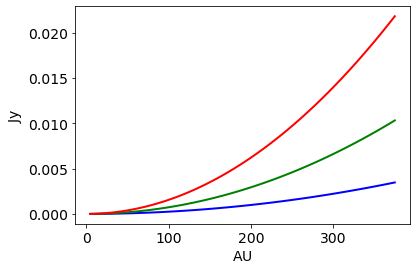

In [14]:
#plot1 = plt.subplot(111)
#plt.figure(figsize=(5,5))
T = 50 * u.K
radii = np.linspace(5, 750/2, 101) * u.AU
#S_nus_3mm = thick_bb_emission(T, B3freq, radii)

plt.plot(radii, S_nus_1mm_20,color = 'b', label = 'BB 20 K')
plt.plot(radii, S_nus_1mm,color = 'g', label = 'BB 50 K')
plt.plot(radii, S_nus_1mm_100,color = 'r', label = 'BB 100 K')


#plt.hist(catB6_m['peak'], bins=np.logspace(-3.5,-1,500), orientation='horizontal', cumulative = True, histtype='step', label = 'Fluxes CDF')
#sns.lineplot(x=catB6_m['peak'], y=norm_cdf)

#plt.axhline(0.000158,color = 'k',alpha = 0.6,  linestyle = '--')#, label = '3mm Faintest source (peak, Jy/beam)')
#plt.axhline(0.0049, color = 'k',alpha = 0.6,  linestyle = '--')#, label = '3mm Brightest source (peak, Jy/beam)')
#plt.axhline(0.00125, color = 'r',alpha = 0.6,  linestyle = '--')#, label = '1mm Fainests source, peak') 
#plt.axhline(0.015, color = 'r',alpha = 0.6,  linestyle = '--')#, label = '1mm Brightest source, peak') 

plt.plot(300,p0_1mm, 'ko', marker=r'$\leftarrow$  0%', markersize=50, clip_on=False)
plt.plot(300,p25_1mm, 'ko', marker=r'$\leftarrow$ 25%', markersize=50, clip_on=False)
plt.plot(300,p50_1mm, 'ko', marker=r'$\leftarrow$ 50%', markersize=50, clip_on=False)
plt.plot(300,p75_1mm, 'ko', marker=r'$\leftarrow$ 75%', markersize=50, clip_on=False)
plt.plot(300,p100_1mm, 'ko', marker=r'$\leftarrow$100%', markersize=50, clip_on=False)



plt.axvline(beam_rad_1mm, label = 'Beam radius', color = 'k', linestyle = '--')

plt.plot(-100,p0_1mm, 'ko', marker=r'$\leftarrow$ %', markersize=40, clip_on=True, label = 'Percentile of detected cores')
#plt.axvline(beam_rad_1mm)

plt.yscale('log')
plt.xlabel('Optically thick source radius (AU)')
plt.ylabel('1 mm flux (Jy)')
#plt.title('BB emission at 1 mm')
plt.xlim(0, 275)
plt.ylim(10**-3, 2*10**-2)
plt.legend()
#plt.savefig('BB_1mm_poster.png', dpi=300,bbox_inches='tight')

/scratch/local/10681038/ipykernel_3735836/3653007974.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(410,p0_3mm, 'ko', marker=r'$\leftarrow$  0%', markersize=50, clip_on=False)
/scratch/local/10681038/ipykernel_3735836/3653007974.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(410,p25_3mm, 'ko', marker=r'$\leftarrow$ 25%', markersize=50, clip_on=False)
/scratch/local/10681038/ipykernel_3735836/3653007974.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(410,p50_3mm, 'ko', marker=r'$\leftarrow$ 50%', markersize=50, clip_on=False)
/scratch/local/10681038/ipykernel_3735836/3653007974.py:24: UserWarning: mark

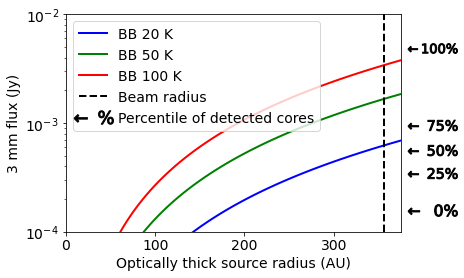

In [15]:
plot1 = plt.subplot(111)
#S_nus_1mm = thick_bb_emission(T, B6freq, radii)
plt.plot(radii, S_nus_3mm_20, color = 'b', label = 'BB 20 K')
plt.plot(radii, S_nus_3mm, color = 'g', label = 'BB 50 K')
plt.plot(radii, S_nus_3mm_100, color = 'r', label = 'BB 100 K')
#plt.plot(radii, S_nus_1mm,color = 'r', label = '1 mm BB')


#plt.hist(catB3_m['peak'], bins=np.logspace(-4,-2,10), orientation='horizontal')
###plt.hist(catB3_m['peak'], bins=np.logspace(-4,-2,500), orientation='horizontal', cumulative = True, histtype='step', label = 'Fluxes CDF')

#plt.axhline(0.000158,color = 'k',alpha = 0.6,  linestyle = '--')#, label = '3mm Faintest source (peak, Jy/beam)')
#plt.axhline(0.0049, color = 'k',alpha = 0.6,  linestyle = '--')#, label = '3mm Brightest source (peak, Jy/beam)')
#plt.axhline(0.00125, color = 'r',alpha = 0.6,  linestyle = '--')#, label = '1mm Fainests source, peak') 
#plt.axhline(0.015, color = 'r',alpha = 0.6,  linestyle = '--')#, label = '1mm Brightest source, peak') 

plt.axvline(beam_rad_3mm, label = 'Beam radius', color = 'k', linestyle = '--')
#plt.axvline(beam_rad_1mm)

#plt.arrow(375, p25, 100, 0.01) # not working well because of log space 
plt.plot(410,p0_3mm, 'ko', marker=r'$\leftarrow$  0%', markersize=50, clip_on=False)
plt.plot(410,p25_3mm, 'ko', marker=r'$\leftarrow$ 25%', markersize=50, clip_on=False)
plt.plot(410,p50_3mm, 'ko', marker=r'$\leftarrow$ 50%', markersize=50, clip_on=False)
plt.plot(410,p75_3mm, 'ko', marker=r'$\leftarrow$ 75%', markersize=50, clip_on=False)
plt.plot(410,p100_3mm, 'ko', marker=r'$\leftarrow$100%', markersize=50, clip_on=False)

#plt.arrow(-0.1, 0.1, 0.8, 0.8, transform=plot1.transAxes, clip_on = False)
plt.plot(-100,p0_1mm, 'ko', marker=r'$\leftarrow$ %', markersize=40, clip_on=True, label = 'Percentile of detected cores')
plt.yscale('log')
plt.xlabel('Optically thick source radius (AU)')
plt.ylabel('3 mm flux (Jy)')
#plt.title('BB emission at 3 mm')
plt.ylim(10**-4, 10**-2)
plt.xlim(0, 375)
plt.legend()
#plt.savefig('BB_3mm.png', dpi=300,bbox_inches='tight')

In [1]:
T_thin = 100 * u.K
T_thick=200*u.K

NameError: name 'u' is not defined

In [35]:
test_den = np.logspace(21,29, 1000) / u.cm**2

In [36]:
test_den_converted = ((test_den * avg_gas_mass).to(u.kg/u.m**2))

In [37]:
mesh_93GHz = total_emission(T_thin, T_thick, freq93, surf_den, r_thick)
mesh_225GHz = total_emission(T_thin, T_thick, freq225, surf_den, r_thick)
SI_mesh = get_SI(mesh_93GHz, mesh_225GHz, freq93, freq225)

surf_den = 2478.185750876745 kg / m2
r_thick[138] = 50.108108108108105 AU
surf_den = 2478.185750876745 kg / m2
r_thick[138] = 50.108108108108105 AU


In [19]:
faint3mm = 0.00016631999460514635
faint1mm = 0.002 # by hand overwrite to account for data convolution

In [38]:
mask = (3.0<SI_mesh)
SI_mesh_cut = np.where(mask, SI_mesh, np.nan)

In [39]:
surf_den_H_2 = np.geomspace(21, np.log10(H_2_den_max.value), 1000)

In [40]:
surf_den_H_2_test = np.log10(test_den.value)

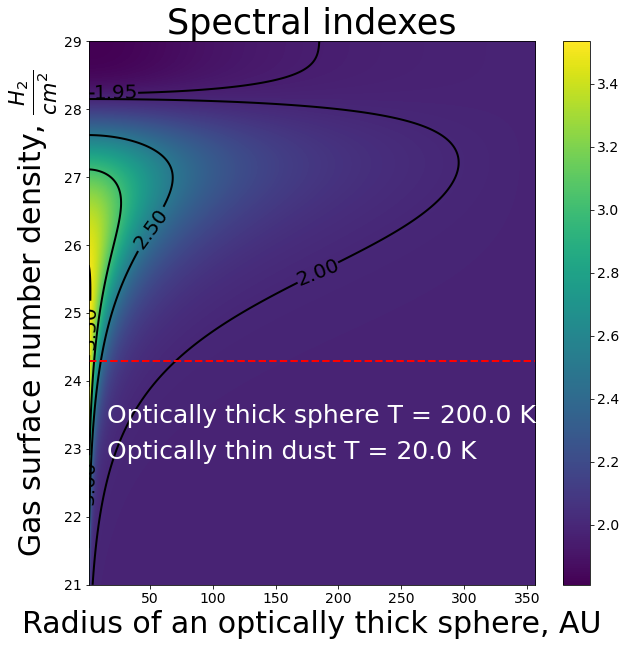

In [41]:
fig = plt.figure(figsize=(10,10))
fontsize = 30
contours = plt.contour(r_thick, surf_den_H_2_test, SI_mesh, 10, colors='black', origin = 'lower', levels = [1.95,2.0, 2.5, 3.0, 3.5])#, extent = [r_min, r_max, 21, 27])
plt.clabel(contours, inline=True, fontsize=20)

minn = 21
maxx = 29

plt.imshow(SI_mesh,origin='lower', extent = [r_min, r_max, minn, maxx], aspect = 'auto')#, norm=LogNorm(vmin=1.8, vmax=3.5))
plt.colorbar()
#plt.imshow(SI_mesh_cut,origin='lower', extent = [r_min, r_max, minn, maxx], aspect = 'auto', cmap = 'inferno', alpha = 0.3, vmin=2, vmax=2, label = 'dd')

#plt.contourf(r_thick, surf_den_H_2, SI_mesh, origin = 'lower', levels=10, alpha = 0.5)

plt.xlabel('Radius of an optically thick sphere, AU', fontsize = fontsize)
plt.ylabel(r'Gas surface number density, $\frac{H_2}{cm^2}$', fontsize = fontsize)
#plt.yscale('log')
plt.title('Spectral indexes', fontsize = fontsize+5)
color = 'w'
fig.text(0.15, 0.3, 'Optically thin dust T = '+str(T_thin), color = color, fontsize = 25)
fig.text(0.15, 0.35, 'Optically thick sphere T = '+str(T_thick), color = color, fontsize = 25)
#fig.text(0.2, 0.3, 'Lowest SI = '+str(np.round(np.nanmin(SI_mesh), 4)), color = color, fontsize = fontsize)
#fig.text(0.2, 0.35, 'Highest SI = '+str(np.round(np.nanmax(SI_mesh), 4)), color = color, fontsize = fontsize)
plt.axhline(24.3, color = 'r', label = 'Average gas density in SgrB2', linestyle = '--')

handles, labels = plt.gca().get_legend_handles_labels()
patch = mpatches.Patch(color = 'grey', label = 'Spectral index > 3.0')
handles.append(patch)

#plt.scatter(50, 25.6)